### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
%matplotlib inline
import seaborn as sns

### Extraindo os Dados

In [6]:
# juntando os Dataframes
df = pd.read_csv('house_price/properties.csv')

### Renomeando as colunas e dropando "Unnamed"

In [15]:
#df.drop(columns='Unnamed: 0', inplace=True)
df.rename(columns={'Address': 'address', 'AreaName': 'area_name', 'Price ($)':'price'}, inplace=True)
df

,Unnamed: 0,address,area_name,price,lat,lng
0,0,"86 Waterford Dr Toronto, ON",Richview,999888,43.679882,-79.544266
1,1,"#80 - 100 BEDDOE DR Hamilton, ON",Chedoke Park B,399900,43.250000,-79.904396
2,2,"213 Bowman Street Hamilton, ON",Ainslie Wood East,479000,43.251690,-79.919357
3,3,"102 NEIL Avenue Hamilton, ON",Greenford,285900,43.227161,-79.767403
4,6,"#1409 - 230 King St Toronto, ON",Downtown,362000,43.651478,-79.368118
...,...,...,...,...,...,...
25346,124922,"3100 CARLING AVENUE UNIT#416 Ottawa, ON",Bayshore,154900,45.353519,-75.807793
25347,124924,"5827 GLADEWOODS PLACE Ottawa, ON",Orléans,624900,45.441273,-75.532745
25348,124925,"6349 DEERMEADOW DRIVE Ottawa, ON",Greely,899000,45.238155,-75.602249
25349,124928,"212 ALVIN ROAD Ottawa, ON",Rockcliffe - Manor Park,295000,45.453838,-75.650040


### Print

In [6]:
print(df.shape)
print(df.isnull().sum())
print(df.head())

(25351, 5)
address        0
area_name    483
price          0
lat            0
lng            0
dtype: int64
                            address          area_name   price        lat  \
0       86 Waterford Dr Toronto, ON           Richview  999888  43.679882   
1  #80 - 100 BEDDOE DR Hamilton, ON     Chedoke Park B  399900  43.250000   
2    213 Bowman Street Hamilton, ON  Ainslie Wood East  479000  43.251690   
3      102 NEIL Avenue Hamilton, ON          Greenford  285900  43.227161   
4   #1409 - 230 King St Toronto, ON           Downtown  362000  43.651478   

         lng  
0 -79.544266  
1 -79.904396  
2 -79.919357  
3 -79.767403  
4 -79.368118  


### Removendo Outliers

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,25351.0,42878.517613,31456.247046,0.0,19940.000000,34037.000000,61501.500000,1.249290e+05
price,25351.0,564543.765137,847596.167337,0.0,219900.000000,371900.000000,619900.000000,3.250000e+07
lat,25351.0,37.326614,82.858347,-999.0,43.401087,43.715977,44.466711,5.385102e+01
lng,25351.0,-85.218379,73.093572,-999.0,-80.308159,-79.503342,-79.107326,1.074519e+00


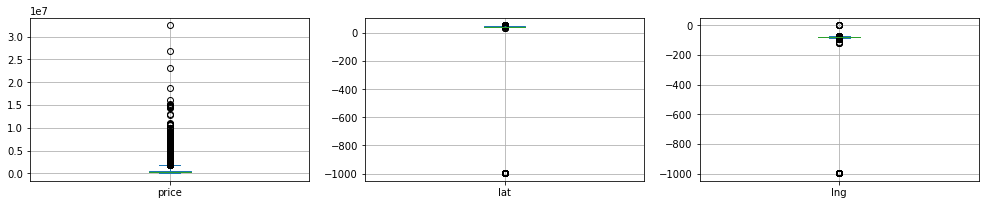

In [17]:
fig,axes = plt.subplots(1,3, figsize=(17,3))
df['price'].plot.box(whis=3, grid=True, ax = axes[0])
df['lat'].plot.box(whis=3, grid=True, ax = axes[1])
df['lng'].plot.box(whis=3, grid=True, ax = axes[2])
plt.show()

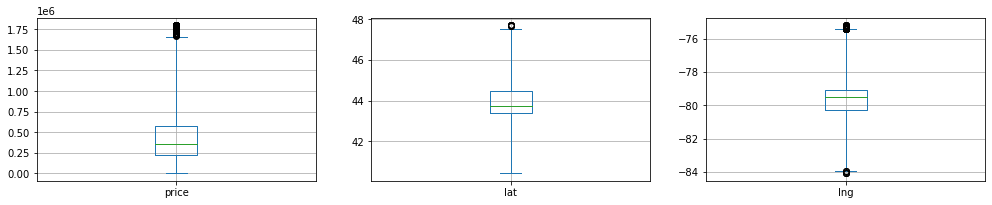

Index(['Unnamed: 0', 'address', 'area_name', 'price', 'lat', 'lng'], dtype='object') (23793, 6)


In [18]:
def remove_outliers(data, *cols):
    for col in cols:
        q1 = data[col].quantile(q = 0.25)
        q3 = data[col].quantile(q = 0.75)
        iqr = q3 - q1
        t1 = q1 - 3 * iqr
        t2 = q3 + 3 * iqr
        data = data[(data[col] > t1) & (data[col] < t2)]
    return data
data_d = remove_outliers(df, 'price', 'lng', 'lat')
data_d.shape
fig,axes = plt.subplots(1,3, figsize=(17,3))
data_d['price'].plot.box(whis=3, grid=True, ax = axes[0])
data_d['lat'].plot.box(whis=3, grid=True, ax = axes[1])
data_d['lng'].plot.box(whis=3, grid=True, ax = axes[2])
plt.show()
print(data_d.columns, data_d.shape)

#### Separando com/sem NaNs

In [19]:
data_withna = data_d.loc[data_d['area_name'].isna()]
data_wona = data_d.loc[data_d['area_name'].notna()]
print(data_withna.shape, data_wona.shape )

(296, 6) (23497, 6)


### Conjunto de dados de treino/teste dividido

In [20]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(data_wona, test_size=0.25, random_state=1)

x_train = training.copy()[['lat', 'lng']]
y_train = training.copy()['area_name']


x_test = testing.copy()[['lat', 'lng']]
y_test = testing.copy()['area_name']

print(training.shape)
print(testing.shape)

(17622, 6)
(5875, 6)


### Criar fluxo de trabalho do classificador de floresta aleatória:

In [21]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(criterion='gini',
                                  n_jobs=16,
                                  max_features = 'auto',
                                  n_estimators = 100,
                                  max_depth = None,
                                  random_state=133)
pipe_clf = Pipeline([
        ('sc', StandardScaler()),
        ('power_trans', PowerTransformer()),
        ('polynom_trans', PolynomialFeatures(degree=2)),
        ('rf_clf', rf_model)
        ])

print(pipe_clf)

Pipeline(steps=[('sc', StandardScaler()), ('power_trans', PowerTransformer()),
                ('polynom_trans', PolynomialFeatures()),
                ('rf_clf',
                 RandomForestClassifier(max_features='auto', n_jobs=16,
                                        random_state=133))])


### Ajustar o modelo e verificar a pontuação de precisão do modelo de floresta aleatória

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

pipe_clf.fit(x_train,y_train)
y_predict = pipe_clf.predict(x_test)

print(f'accuracy score is: {accuracy_score(y_test, y_predict)}')

C:\Users\Jhon Anderson\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


accuracy score is: 0.918468085106383


#### Aplique o modelo para preencher qualquer AreaName ausente

In [13]:
import warnings
warnings.filterwarnings('ignore')
data_withna['area_name'] = pipe_clf.predict(data_withna[['lat', 'lng']])
data_withna.head()

,address,area_name,price,lat,lng
209,"7393 Wellington Rd 51 . Ariss, ON",Guelph,699000,43.596718,-80.340660
1186,"152 MARR Drive Elora, ON",Elora,399900,43.693314,-80.437492
2773,"17 Dan Sheehan Lane Clarington, ON",Bowmanville,550000,43.931091,-78.707405
2874,328 Wicklow Beach Rd Alnwick Haldimand Townshi...,Colborne,629000,43.976543,-77.962921
2936,"WALKER LAKE DR WALKER LAKE DR Lake Of Bays, ON",Huntsville,69900,45.378361,-79.092339


### Combine Dois Formulários e Exporte

In [14]:
data_f = pd.concat([data_wona, data_withna])
data_f.head()
# data_f.to_csv('properties_output.csv')

,address,area_name,price,lat,lng
0,"86 Waterford Dr Toronto, ON",Richview,999888,43.679882,-79.544266
1,"#80 - 100 BEDDOE DR Hamilton, ON",Chedoke Park B,399900,43.250000,-79.904396
2,"213 Bowman Street Hamilton, ON",Ainslie Wood East,479000,43.251690,-79.919357
3,"102 NEIL Avenue Hamilton, ON",Greenford,285900,43.227161,-79.767403
4,"#1409 - 230 King St Toronto, ON",Downtown,362000,43.651478,-79.368118


In [15]:
data_g = data_f.groupby('area_name').mean()
data_g['count'] = data_f.groupby('area_name').count()['lat']
mean_lat = data_g['lat'].mean()
mean_lng = data_g['lng'].mean()

data_g.sort_values('price', ascending=False, inplace=True)

print(data_g)

                                          price        lat        lng  count
area_name                                                                   
Winona                             1.595000e+06  43.213367 -79.656593      1
Armour Heights                     1.590000e+06  43.743423 -79.426872      1
Yonge and Lawrence                 1.589000e+06  43.728615 -79.402267      1
Oro Station                        1.525000e+06  44.423679 -79.549232      1
Old Mill                           1.524333e+06  43.651253 -79.493347      3
...                                         ...        ...        ...    ...
Manitowaning                       1.499900e+04  45.739494 -81.807777      1
Trillium Industrial Park           3.800000e+03  43.414257 -80.449989      1
Bishop Hellmuth Heritage District  1.883333e+03  42.996292 -81.251495      3
North End West                     0.000000e+00  43.269379 -79.865402      1
Port Lands                         0.000000e+00  43.647285 -79.351509      1

#### mediana dos preços de Ontário

In [9]:
df['price'].median()

371900.0

### Mapa.

#### Mapa Dos Preços Em Ontário

In [16]:
from folium.plugins import MarkerCluster

on_map_d = folium.Map(location=[mean_lat, mean_lng], zoom_start=10)

# create a mark cluster object
marker_cluster = MarkerCluster().add_to(on_map_d) 

# add data point to the mark cluster
for i in range(len(data_g)):
    area_name = data_g.iloc[i].name
    price = round(data_g.iloc[i]['price'])
    lat = data_g.iloc[i]['lat']
    lng = data_g.iloc[i]['lng']
    cnt = round(data_g.iloc[i]['count'])
    marker_text = f'{area_name}\nPrice:{price}\nSize: {cnt}'
    folium.Marker(
        location=[lat, lng],
        popup=marker_text,
        icon=None
    ).add_to(marker_cluster)
on_map_d.add_child(marker_cluster)

### Mapa De Calor Dos Preços Das Casas

In [17]:
# Heat map of house prices

from folium.plugins import HeatMap
on_map_d = folium.Map(location=[mean_lat, mean_lng], zoom_start=10)
HeatMap(data_g[['lat', 'lng', 'price']]).add_to(on_map_d)
on_map_d

### Extra  - Criando um TOP 20 Rank por área

<AxesSubplot:title={'center':'Top 20 Areas by Number of Houses on Sale'}>

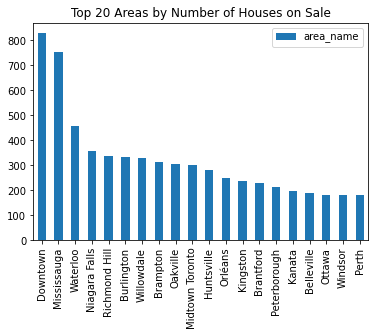

In [20]:
qt_houses = pd.DataFrame(df1['area_name'].value_counts())
qt_houses.sort_values(by='area_name')
qt_houses[0:20].plot(kind='bar', title='Top 20 Areas by Number of Houses on Sale')